In [97]:
import collections
import os
import pathlib
import json

DATA_DIR = (pathlib.Path('.') / 'data').absolute()
techniques_count = collections.defaultdict(int)

def list_data():

    for fn in os.listdir(DATA_DIR):
        if not fn.endswith('.json'):
            continue

        data_path = DATA_DIR / fn
        with data_path.open() as f:
            data = json.load(f)

        yield data


def plot(title, pos, values, tick_labels, figsize, n_locator = 9):
    max_value = max(values)
    fig, ax = plt.subplots(figsize=figsize)
    fig.canvas.set_window_title(title)
    rects = ax.barh(pos, values, align='center', height=0.5, tick_label=tick_labels)
    ax.set_title(title)
    ax.set_xlim([0, max_value + max_value * 0.1])
    ax.xaxis.set_major_locator(MaxNLocator(n_locator))
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)
    ax.axvline(50, color='grey', alpha=0.25)
    plt.show()

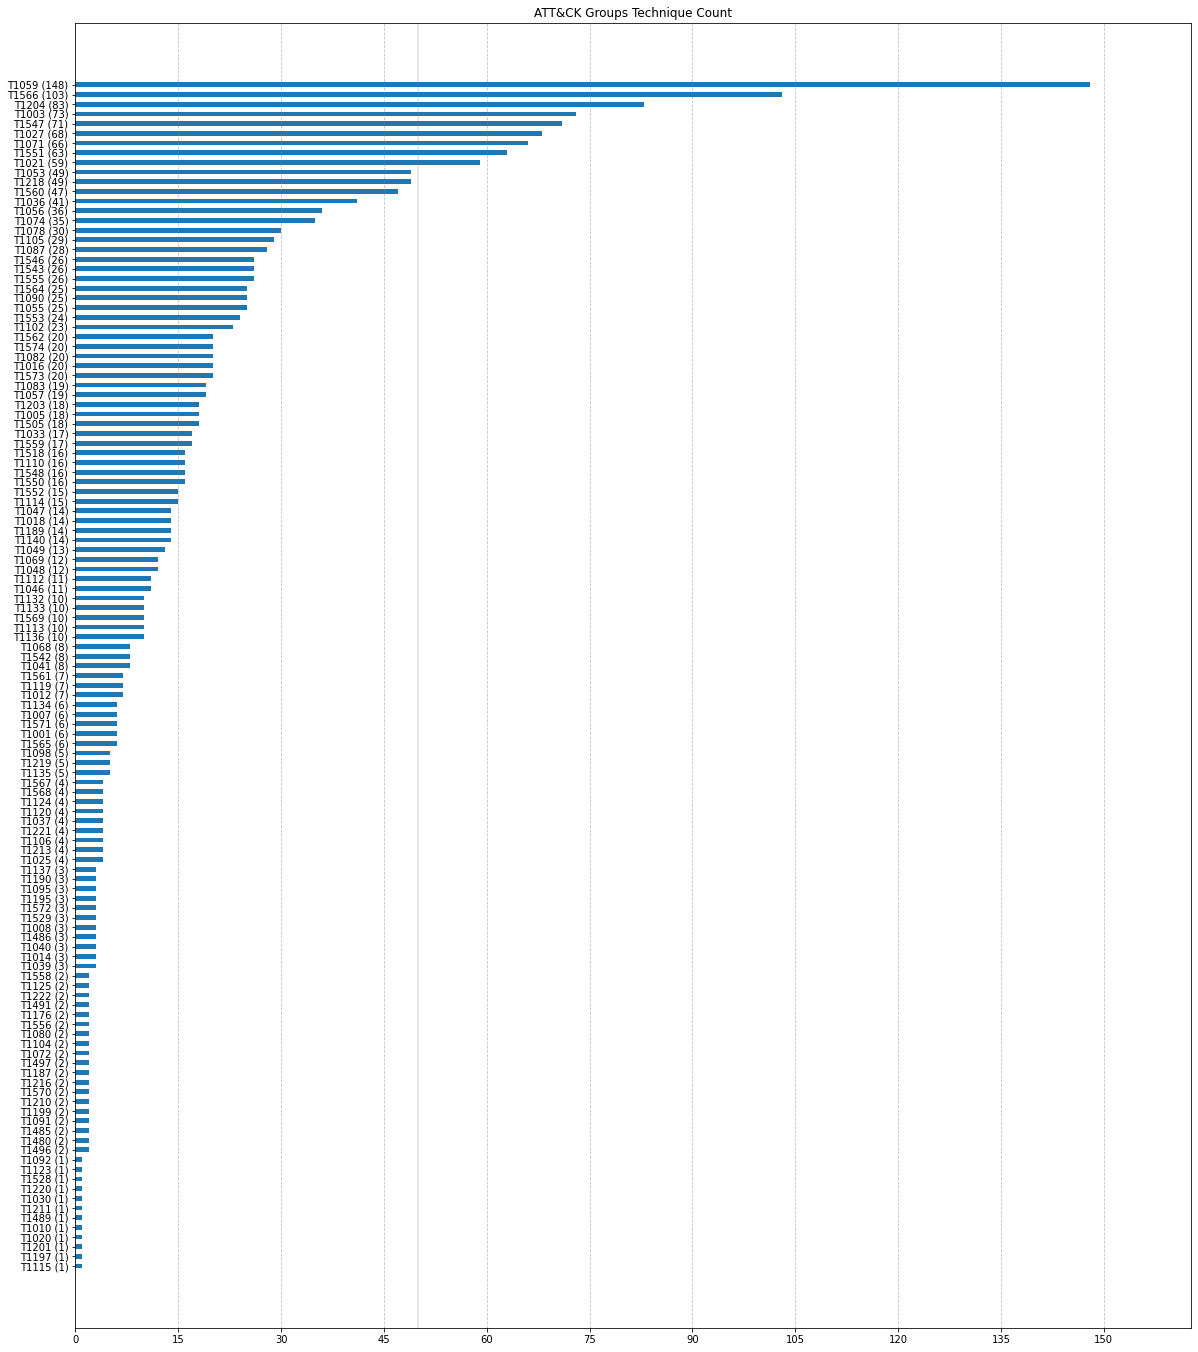

In [98]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

technique_ids = set()
for data in list_data():
    for tech in data['techniques']:
        tech_id = tech['techniqueID'].split('.')[0]
        techniques_count[tech_id] += 1
        technique_ids.add(tech_id)
technique_ids = sorted(technique_ids, key=lambda tech_id: techniques_count[tech_id])

plot(
    'ATT&CK Groups Technique Count', 
    np.arange(len(technique_ids)), 
    [techniques_count[tech_id] for tech_id in technique_ids],
    list(map(lambda tech_id: f'{tech_id} ({techniques_count[tech_id]})', technique_ids)),
    figsize=(20, 24),
    n_locator=11,
)

In [100]:
import requests

from crawler import crawl_enterprise_matrix

matrix = crawl_enterprise_matrix(requests.Session())
group_techniques = collections.defaultdict(set)
for data in list_data():
    group_name = data['name'].split()[0]
    for tech in data['techniques']:
        tech_id = tech['techniqueID'].split('.')[0]
        group_techniques[group_name].add(tech_id)

group_tech_matrix = np.zeros([len(group_techniques), len(technique_ids)], dtype=np.float64)
for i, group_name in enumerate(group_techniques):
    row = group_tech_matrix[i]
    techniques = group_techniques[group_name]
    for j, tech_id in enumerate(technique_ids):
        row[j] = 1 if tech_id in techniques else 0
    row /= row.sum()

tech_group_matrix = np.transpose(group_tech_matrix)

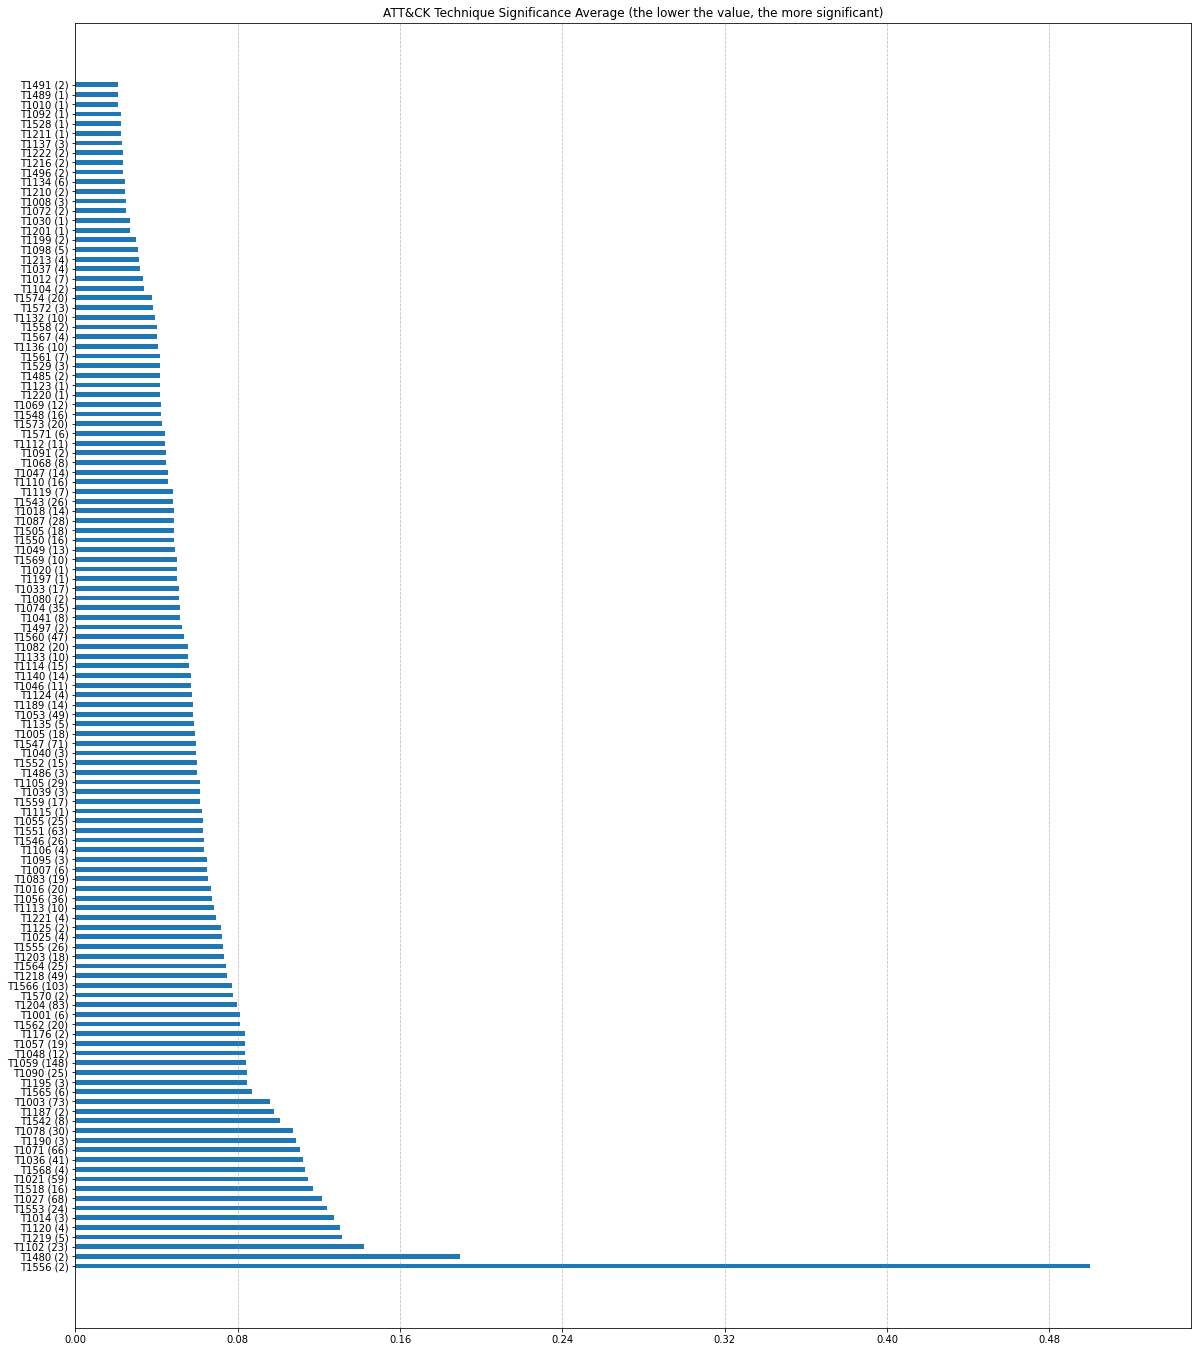

In [102]:
Significance = collections.namedtuple('Significance', 'tech_id, avg')
Significance.__slots__ = ('tech_id', 'avg',)
tech_significances = [0] * len(technique_ids)
avg_sum = 0
for i, row in enumerate(tech_group_matrix):
    avg = np.average(row[row != 0])
    tech_significances[i] = Significance(technique_ids[i], avg)
    avg_sum += avg

for tech_sig in tech_significances:
    tech_sig._replace(avg=tech_sig.avg / avg_sum)

tech_significances.sort(key=lambda sig: sig.avg, reverse=True)
tick_labels = []

for tech_sig in tech_significances:
    tick_labels.append(f'{tech_sig.tech_id} ({techniques_count[tech_sig.tech_id]})')

plot(
    'ATT&CK Technique Significance Average (the lower the value, the more significant)',
    np.arange(len(technique_ids)), 
    [tech_sig.avg for tech_sig in tech_significances],
    tick_labels,
    figsize=(20, 24),
)

In [103]:
a = np.array(sorted(list(techniques_count.values())))
selected_tech_significances = list(filter(lambda tech_sig: tech_sig.avg > 0.06 and techniques_count[tech_sig.tech_id] > 8, tech_significances))
selected_tech_significances.sort(key=lambda tech_sig: tech_sig.avg)

def find_info_of_tech(tech_id):
    for tactic in matrix:
        for tech in matrix[tactic]:
            if tech.id == tech_id:
                return tactic, tech
    return None

significant_tactic_count = collections.defaultdict(int)

print('Criteria: Significance Average > 0.06 && Occurrence Count > 5\n')
print('===== Most significant techniques =====')
for tech_sig in selected_tech_significances:
    tactic, tech = find_info_of_tech(tech_sig.tech_id)
    significant_tactic_count[tactic] += 1
    print(f'{tactic:25}{tech_sig.avg:.5f} {tech.id} {tech.name}')

print('\n===== Most significant tactics =====')
items = sorted(significant_tactic_count.items(), key=lambda item: item[1], reverse=True)
for tactic, count in items:
    print(f'{tactic:25}{count}')

Criteria: Significance Average > 0.06 && Occurrence Count > 5

===== Most significant techniques =====
Command and Control      0.06119 T1105 Ingress Tool Transfer
Execution                0.06143 T1559 Inter-Process Communication
Privilege Escalation     0.06285 T1055 Process Injection
Defense Evasion          0.06295 T1551 Indicator Removal on Host
Persistence              0.06320 T1546 Event Triggered Execution
Discovery                0.06536 T1083 File and Directory Discovery
Discovery                0.06660 T1016 System Network Configuration Discovery
Credential Access        0.06716 T1056 Input Capture
Collection               0.06834 T1113 Screen Capture
Credential Access        0.07257 T1555 Credentials from Password Stores
Execution                0.07302 T1203 Exploitation for Client Execution
Defense Evasion          0.07407 T1564 Hide Artifacts
Defense Evasion          0.07482 T1218 Signed Binary Proxy Execution
Initial Access           0.07730 T1566 Phishing
Execution    